# Environment: Python 3.5

In [3]:
from ast import literal_eval
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
from sklearn.preprocessing import normalize

import seaborn as sns
import datetime
import json
import numpy as np
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
from ast import literal_eval

# For Python2 this have to be done
# from __future__ import division


import gzip
import string
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [4]:
ITEM_ID = 'business_id'
USER_ID = 'user_id'
RATING = 'rating'
BINARY_RATING = 'Binary'
REVIEW_TEXT = 'review_text'
TIMESTAMP = 'review_date'
# TIMESTAMP = 'timestamp'
DATA_PATH = '../../data/yelp/'
DATA_NAME = 'toronto_reviews.csv'

In [6]:
# Load Original Data

dataset_name = 'yelp'

df = pd.read_csv('../../data/'+ dataset_name +'/toronto_reviews.csv')
# df_train = pd.read_csv('../../data/'+ dataset_name +'/Train.csv')
# df_valid = pd.read_csv('../../data/'+ dataset_name +'/Valid.csv')
# df_test = pd.read_csv('../../data/'+ dataset_name +'/Test.csv')
# key_phrase = pd.read_csv('../data/'+ dataset_name +'/KeyPhrases.csv')

In [10]:
df.head()

,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,review_count,review_date,...,review_language,review_text,ufc,user_id,user_loc,vote_count,Updated,Year,Month,Day
0,bSQGCheX1BwvL67Az1OJlA,90,False,[],[],False,231.0,5.0,82,"['9', '5', '2018']",...,en,I had a good experience at this store. I was g...,"[10, 1, 10]",q41qqkChL9fRxF43cnkgbw,"Houston, TX",11.0,False,2018,5,9
1,bSQGCheX1BwvL67Az1OJlA,0,False,[],[],False,9.0,1.0,43,"['3', '6', '2018']",...,en,I reaaaaaally wish I had read all the stories ...,"[0, 0, 0]",tNT5I9-QcljS-7w_doXCXQ,"Toronto, Canada",0.0,False,2018,6,3
2,bSQGCheX1BwvL67Az1OJlA,52,False,"[""Photo of Sleep Country - Toronto, ON, Canada...",['https://s3-media1.fl.yelpcdn.com/bphoto/E_gL...,False,27.0,1.0,31,"['7', '30', '2016']",...,en,Everything was fine until the delivery. I wait...,"[3, 1, 2]",9q1Do6TVM27RNHUQAQxPRg,"Toronto, Canada",3.0,False,2016,30,7
3,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,3,"['12', '16', '2018']",...,en,"Thought I had bed bugs, but it turned out to b...","[0, 0, 0]",cr-4gAf1_seYWLoO59Lp4w,"Old Toronto, Toronto, Canada",0.0,False,2018,16,12
4,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,5,"['8', '6', '2014']",...,en,"When we called, Mr. Akram was willing to come ...","[1, 0, 0]",CQkTIyhNczRlRI4kIdAzSw,"Toronto, Canada",1.0,False,2014,6,8


In [8]:
df = df.drop(["Unnamed: 0", "Unnamed: 0.1"],axis = 1)

In [11]:
df[ITEM_ID].nunique()

32022

In [12]:
df[USER_ID].nunique()

128419

In [13]:
def filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=True, 
                   user_review_threshold=10, item_review_threshold=10, 
                   num_user=None, num_item=None, user_ratio=0.25, item_ratio=0.2):
    # Binarize rating
    df[BINARY_RATING] = (df[RATING] > threshold)*1

    # Filter dataset only based on positive ratings
    df = df[df[BINARY_RATING] == 1]
    
    print("The total number of users is {}".format(df[USER_ID].nunique()))
    print("The total number of items is {} \n".format(df[ITEM_ID].nunique()))
    

    values = df[ITEM_ID].value_counts().keys().tolist()
    counts = df[ITEM_ID].value_counts().tolist()
    item_df = pd.DataFrame.from_dict({ITEM_ID: values, "count": counts})
    
    values = df[USER_ID].value_counts().keys().tolist()
    counts = df[USER_ID].value_counts().tolist()
    user_df = pd.DataFrame.from_dict({USER_ID: values, "count": counts})
    
    if popularity:
        print("Filter dataset by popularity. \n")
        
        if filter_by_review_count:
            print("Filter dataset by review count. \n")
            
            filtered_item_df = item_df[item_df["count"] >= item_review_threshold]
            filtered_item_id = filtered_item_df[ITEM_ID].values
            
            filtered_user_df = user_df[user_df["count"] >= user_review_threshold]
            filtered_user_id = filtered_user_df[USER_ID].values
            
        else:
            print("Filter dataset by user and item number. \n")
            filtered_item_id = item_df[ITEM_ID].unique()[:num_item]
            filtered_user_id = user_df[USER_ID].unique()[:num_user]
            
    else:
        print("Filter dataset by sampling. \n")
        np.random.seed(8292)
        
        filtered_item_id = np.take(item_df[ITEM_ID].unique(), 
                                   indices=np.random.choice(len(item_df), int(item_ratio*len(item_df))))
        filtered_user_id = np.take(user_df[USER_ID].unique(), 
                                   indices=np.random.choice(len(user_df), int(user_ratio*len(user_df))))
        
    df = df.loc[(df[USER_ID].isin(filtered_user_id)) & (df[ITEM_ID].isin(filtered_item_id))]
    
    print("Number of User: {}".format(df[USER_ID].nunique()))
    print("Number of Item: {}".format(df[ITEM_ID].nunique()))

    return df

# Filter the dataset by popularity then by number of users and items

In [14]:
filtered_df = filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=True, 
                             user_review_threshold=10, item_review_threshold=10, 
                             num_user=8000, num_item=4000, user_ratio=None, item_ratio=None)

The total number of users is 90758
The total number of items is 27896 

Filter dataset by popularity. 

Filter dataset by review count. 

Number of User: 5937
Number of Item: 7895


# Analyze filtered dataset

In [15]:
filtered_df = filtered_df.reset_index(drop = True)

In [16]:
filtered_df.head()

,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,review_count,review_date,...,review_text,ufc,user_id,user_loc,vote_count,Updated,Year,Month,Day,Binary
0,Xo1LNzhnwE-ilqsM3ybs9Q,105,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tu7j...,False,325.0,4.0,122,"['8', '23', '2016']",...,I ordered the lemon mango slush and the lemon ...,"[1, 1, 1]",zsJFjhBQEFQ6gJ7BsNM_Ug,"Toronto, Canada",1.0,False,2016,23,8,1
1,Xo1LNzhnwE-ilqsM3ybs9Q,239,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tS6Y...,False,78.0,5.0,49,"['11', '6', '2016']",...,{Grapefruit & Yakult Green Tea with Aloe Jelly...,"[0, 0, 0]",C91it8b3odRg0503asUaJA,"Markham, Canada",0.0,False,2016,6,11,1
2,Xo1LNzhnwE-ilqsM3ybs9Q,10,False,"['Photo of Happy Lemon - Markham, ON, Canada',...",['https://s3-media3.fl.yelpcdn.com/bphoto/rfB0...,False,504.0,4.0,164,"['9', '25', '2016']",...,Saw this newly opened bubble tea shop and want...,"[0, 0, 0]",dAB-v4B-5_8QgTcoVSnZOw,"Vaughan, Canada",0.0,False,2016,25,9,1
3,Xo1LNzhnwE-ilqsM3ybs9Q,80,False,"['Photo of Happy Lemon - Markham, ON, Canada',...",['https://s3-media1.fl.yelpcdn.com/bphoto/2jVn...,False,743.0,5.0,128,"['6', '30', '2018']",...,Happy Lemon has become my new favourite place ...,"[5, 0, 0]",Dt_h4Dt0lVblqRxLLV25YQ,"Markham, Canada",5.0,False,2018,30,6,1
4,Xo1LNzhnwE-ilqsM3ybs9Q,250,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media3.fl.yelpcdn.com/bphoto/yWze...,False,707.0,4.0,52,"['1', '28', '2018']",...,"As ""temporary"" duchess I guess I'll finally wr...","[1, 0, 0]",L_OxAt1gt9l1gokgGoW7Sg,"Markham, Canada",1.0,False,2018,28,1,1


In [17]:
values = filtered_df[USER_ID].value_counts().keys().tolist()
counts = filtered_df[USER_ID].value_counts().tolist()
user_df = pd.DataFrame.from_dict({USER_ID: values, "count": counts})

values = filtered_df[ITEM_ID].value_counts().keys().tolist()
counts = filtered_df[ITEM_ID].value_counts().tolist()
item_df = pd.DataFrame.from_dict({ITEM_ID: values, "count": counts})

In [18]:
item_df.tail()

,business_id,count
7890,o5R8XHxSudzAFbeXJY3aSw,1
7891,xTqvWZGe6rANO7bAoE_c0g,1
7892,m1MD1SzBPMOoGfLEFNP2yA,1
7893,wSNFfVa3ijabhCw2vQ3x1w,1
7894,cSHlKFMS_yWhHfbUXw2OyQ,1


In [19]:
item_df["count"].mean()

18.56529449018366

In [20]:
user_df[user_df["count"] >= 20]

,count,user_id
0,634,CxDOIDnH8gp9KXzpBHJYXw
1,445,Q9mA60HnY87C1TW5kjAZ6Q
2,310,WeVkkF5L39888IPPlRhNpg
3,293,FREeRQtjdJU83AFtdETBBw
4,282,ic-tyi1jElL_umxZVh8KNA
5,274,JrXC_MDp38BWwLn2SFdNsA
6,240,0BBUmH7Krcax1RZgbH4fSA
7,239,Nq6e5N8bjgD9B46O4va_zA
8,219,j6wLUT0ZXi-x0otelYIFpA
9,218,aX6_Pf3njB-H3FrqgnNJ2g


In [21]:
users = user_df[user_df["count"] >= 20][USER_ID].values

In [ ]:
pos_df = filtered_df.loc[filtered_df[USER_ID].isin(users)].reset_index(drop=True)
# pos_df

# Export the filtered dataset

# pos_df.to_csv(DATA_PATH+DATA_NAME+".csv", header=False)

In [23]:
items = pos_df[ITEM_ID].values

# Get the Final DF with reviews

In [ ]:
cur_df = df.loc[(df[USER_ID].isin(users)) & (df[ITEM_ID].isin(items))].reset_index(drop=True)
# cur_df

In [25]:
cur_df[USER_ID].nunique()

2343

In [26]:
cur_df[ITEM_ID].nunique()

7456

# Split dataset 

In [214]:
# No split is done for now

# Pre-process Reviews

In [29]:
def preprocess(text):
#     text = text.replace('.',' ').replace('/',' ').replace('quot;', ' ').replace('amp;', '').replace('-', ' ')
    
    text = text.replace('.',' ').replace('/t',' ').replace('\t',' ').replace('/',' ').replace('-',' ')
    
    # Tokenize
    text = nltk.word_tokenize(text)
    
    # Lowercase
    text = [w.lower() for w in text]

    # Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text]

    # Remove tokens that are not alphabetic
    text = [w for w in text if w.isalpha()]

    # Remove Stopwords
    # Get english stopwords
    en_stopwords = set(stopwords.words('english'))
    en_stopwords.remove('off')
    text = [w for w in text if w not in en_stopwords]
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]

    text = " " + " ".join(str(x) for x in text) + " "

    text = text.replace('whitish', 'white')
    text = text.replace('bisquity', ' biscuit ')
    text = text.replace('carmel', ' caramel ')
    text = text.replace('flower', ' floral ')
    text = text.replace('piny', ' pine ')
    text = text.replace('off white', 'offwhite')
    text = text.replace('goden', 'gold')
    text = text.replace('yello', 'yellow')
    text = text.replace('reddish', ' red ') 
    

    # Reset to token
    text = nltk.word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text]
    text = [w for w in text if w.isalpha()]
#     en_stopwords = set(stopwords.words('english'))
    text = [w for w in text if w not in en_stopwords]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    
    return text
    
cur_df["review"] = cur_df[REVIEW_TEXT].apply(preprocess)
cur_df["conca_review"] = cur_df["review"].apply(lambda x: " " + " ".join(str(x) for x in x) + " ")

cur_df.to_pickle('../../data/yelp/cur_df.pkl')

# Index words since no further changes will be made on the words

In [32]:
tokenizer = Tokenizer()
token_list = cur_df["review"].tolist()
tokenizer.fit_on_texts(token_list)

In [33]:
df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])

In [ ]:
df_word_index

In [ ]:
df_word_index

In [35]:
token_flatten_list = [item for sublist in token_list for item in sublist]

In [36]:
total_token = len(token_flatten_list)
total_token

12369650

In [37]:
from nltk.probability import FreqDist

fdist1 = FreqDist(token_flatten_list)

In [ ]:
# fdist1.most_common(250)

In [ ]:
# Keyphrases are chosen mannually from top-1000 
fdist1.most_common(1000)

In [185]:
category_key = ['chinese', 'fast', 'thai', 'bar', 'fry', 'fried', 'dessert', 'dinner', 'lunch', 'soup', 'green', 
                'mexico', 'italy','mexican','vietnamese','buffet','takeout','casual','pub','bakery','indian','classic',
               'modern','french','italian','asian','birthday', 'vegetarian', 'downtown', 'bbq','japanese','breakfast','seafood',
               'brunch'] 

food_key = ['taco', 'curry', 'potato', 'crispy', 'shrimp', 'bread', 'chocolate', 'ramen', 'pizza', 'beer', 'sandwich', 'cake',
            'sushi', 'egg', 'fish', 'coffee', 'ice', 'burger', 'cheese', 'cream', 'salad', 'pork', 'beef', 'tea', 'noodle',
           'meat', 'rice', 'chicken', 'dim sum', 'cocktail', 'ice cream','squid','tempura','tapioca','donut','olive',
            'espresso','octopus','croissant','banana','cookie','honey','cone','scallop','congee',
           'skewer','miso','lettuce','pop','strawberry','apple','avocado','juice','booth','calamari','kimchi','patty',
           'sesame','tart','four','crepe','tuna','wrap','lemon','vegan','coconut','corn','poutine','toast','belly','bubble',
           'oyster','cocktail', 'cheesecake', 'fruit', 'sausage','latte','matcha','pancake','duck','tofu','sashimi',
           'lamb','mango','bacon','tomato','lobster','wine','rib','waffle','bun','wing','dumpling','bean','steak','salmon',
           'pasta','milk','fried chicken','milk tea','green tea','bubble tea','pork belly','spring roll','fried rice',
            'pork bone soup']
seasoning=['sugar','oil','soy','leaf','spice','butter','ginger','pepper','peanut','garlic']
infrastruture_key = ['street', 'parking', 'store','shopping','nail','theatre','skin','movie','corner','neighbourhood','washroom',
                    'window','station','chair','queen','king','markham','plaza','market','spring', 'mall']
# or we call this comment
service_key = ['quick', 'clean', 'busy', 'fresh', 'friendly','convenient','refill','soggy','greeted','bright','crowded','overpriced',
              'cheaper','immediately','dog','quiet','efficient','spacious','pleasant','fair','complaint','disappointing','fancy',
             'comfortable', 'dark','cozy','helpful','tax','nicely','honestly', 'pricey','yummy','music','chip','attentive',
              'reasonable','wait']

taste_key = ['traditional', 'spicy','flavorful','fluffy','smooth','frozen','sweetness','art','mayo','gravy','healthy','rare',
            'refreshing','crunchy','chili','crust','stick','steamed','greasy','dip','gelato','salt','stuffed','topped','smoked',
            'roasted','seasoned','chewy','pot','solid','sour', 'baked', 'juicy','creamy','deep fried']

bigram_key = ['ice cream', 'come back', 'go back', 'fried chicken', 'deep fried', 'milk tea', 'green tea', 'bubble tea',
             'pork belly', 'pad thai', 'spring roll', 'fried rice']

In [186]:
key = category_key + food_key + infrastruture_key + service_key + taste_key
len(category_key) + len(food_key) + len(infrastruture_key) + len(service_key) + len(taste_key)

233

In [56]:
fdist1['chinese']

9505

In [57]:
# A lot of chinese restuarants
len(cur_df[cur_df["conca_review"].str.contains('chinese', regex=False)])

6590

In [59]:
# Not that much italy resturants
len(cur_df[cur_df["conca_review"].str.contains('italy', regex=False)])

542

In [62]:
# Not that much mexico resturants
len(cur_df[cur_df["conca_review"].str.contains('mexico', regex=False)])

264

In [61]:
# But a lot of tacos 
len(cur_df[cur_df["conca_review"].str.contains('taco', regex=False)])

4105

In [67]:
len(cur_df[cur_df["conca_review"].str.contains('traditional', regex=False)])

3569

In [72]:
len(cur_df[cur_df[REVIEW_TEXT].str.contains('traditional burger', regex=False)])

14

In [93]:
len(cur_df[cur_df[REVIEW_TEXT].str.contains('cocktail', regex=False)])

3216

In [89]:
list_1 = np.array(cur_df[cur_df["conca_review"].str.contains('chinese', regex=False)].index)
len(list_1)

6590

In [90]:
list_2 = np.array(cur_df[cur_df["conca_review"].str.contains('chinese dim sum', regex=False)].index)
len(list_2)

73

In [91]:
np.setdiff1d(list_2,list_1)

array([], dtype=int64)

In [80]:
cur_df.iloc[157037, :]["conca_review"]

' customer service price amazing turn around fast beyond impressed everyone dealt professional friendly knowledgeable would highly recommend '

In [81]:
cur_df.iloc[1101, :][REVIEW_TEXT]

'AMAZING. \xa0Lost of choice and staff are very friendly!'

In [84]:
cur_df[cur_df["conca_review"].str.contains('chinese', regex=False)][REVIEW_TEXT].values[20]

"I have been here quite a few times now for dim sum, for their dinner service, and for a banquet. First off, beware of the parking lot area near the entrance of this restaurant - there always a lot of cars in the area of the parking lot I find. Secondly, if possible, try to make reservations - I generally like to make reservations so then I can minimize the wait time for a table especially during the dim sum service. Dim sum at this place is good - the price is reasonable and food quality is good. Dinner service here is good too. I would say the dinner service, food quality for the dinner menu, and the prices are en par with the Chinese restaurants in the area. Their Chinese bbq items are a must try in my option. However, why I gave it a three star - saying this place is only average was because of a recent banquet I attended here for a friend's wedding. I was one of her helpers for set up before cocktail hour started. They were not set up on time and they kind of messed up the floor p

In [50]:
cur_df[cur_df["conca_review"].str.contains('pepper', regex=False)]["conca_review"].values[2220]

' definitely screaming ice cream excited place opening especially closer fairly new cute little place cookie cutter flavour like pink peppercorn black sesame roasted banana visit flavour select least another counted flavour cycle yum price fair scoop scoop l scoop service great girl working super sweet helpful recommending flavour vegan patron happy know vegan flavour available recommend peach sorbet definitely back soon pistachio calling name '

In [51]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()
# lemma_flat = [lemmatizer.lemmatize(w) for w in flat_list]

lemmatizer.lemmatize("toasted")

'toasted'

# Define Bigram Right Type (ADJ/NN)

In [105]:
#function to filter for ADJ/NN bigrams
def filter_type(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS')
    ins = ('IN','TO')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    
    if len(tags) == 2:
        if tags[0][1] in acceptable_types and tags[1][1] in second_type:
            return True
        else:
            return False
    elif len(tags) == 3:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in second_type:
            return True
        else:
            return False
    else:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in acceptable_types and tags[3][1] in second_type:
            return True
        else:
            return False 

# Bi-gram

In [102]:
bigrams = nltk.collocations.BigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
bigramFinder.apply_freq_filter(100)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['ngram','freq']).sort_values(by='freq', ascending=False)

In [104]:
bigramFreqTable[bigramFreqTable["ngram"].str.contains('dim', regex=False)][:250]['ngram'].values

array([('dim', 'sum'), ('dim', 'lighting'), ('place', 'dim'),
       ('good', 'dim')], dtype=object)

In [ ]:
for i in bigramFreqTable[:100]['ngram']:
    print (i)

In [115]:
bigram_key = ['ice cream', 'come back', 'go back', 'fried chicken', 'deep fried', 'milk tea', 'green tea', 'bubble tea',
             'pork belly', 'pad thai', 'spring roll', 'fried rice']

In [110]:
bigramFreqTable[bigramFreqTable["ngram"].str.contains('dim', regex=False)][:250]['ngram'].values

array([('dim', 'sum'), ('dim', 'lighting'), ('place', 'dim'),
       ('good', 'dim')], dtype=object)

In [109]:
bigramFreqTable[bigramFreqTable["ngram"] == ("dim", "sum")]

,ngram,freq
5248,"(dim, sum)",5182


# Bi-gram PMI

In [ ]:
bigramFinder.apply_freq_filter(100)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                              columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

bigramPMITable

In [ ]:
bigramPMITable = bigramPMITable[bigramPMITable.bigram.map(lambda x: filter_type(x))]
bigramPMITable

In [125]:
bigram_freq_pmi = pd.merge(bigramFreqTable, bigramPMITable, how='right', left_on='ngram', right_on='bigram').sort_values("PMI", ascending=False)
bigram_freq_pmi.head(50)

,ngram,freq,bigram,PMI
1372,"(cornish, hen)",134,"(cornish, hen)",15.635666
1071,"(hustle, bustle)",160,"(hustle, bustle)",15.420942
1905,"(sneaky, dee)",101,"(sneaky, dee)",15.393156
1544,"(lactose, intolerant)",121,"(lactose, intolerant)",14.845034
855,"(dietary, restriction)",193,"(dietary, restriction)",14.707485
791,"(obligatory, catchy)",204,"(obligatory, catchy)",14.542729
472,"(swiss, chalet)",299,"(swiss, chalet)",14.134647
934,"(obligatory, title)",180,"(obligatory, title)",13.499966
1859,"(arctic, char)",103,"(arctic, char)",13.473019
1272,"(gong, cha)",141,"(gong, cha)",13.062775


# Trigram

In [126]:
trigrams = nltk.collocations.TrigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
trigram_freq = trigramFinder.ngram_fd.items()

trigramFreqTable = pd.DataFrame(list(trigram_freq), 
                                columns=['ngram','freq']).sort_values(by='freq', ascending=False)

In [127]:
trigramFreqTable = trigramFreqTable[trigramFreqTable["freq"] >= 10]

In [ ]:
trigramFreqTable

In [ ]:
trigram_key = ['pork bone soup' ]

# Keyphrases

In [187]:
df_keyphrases = pd.DataFrame.from_items([("Phrases", key)])
keyphrases = df_keyphrases['Phrases'].tolist()
df_keyphrases

,Phrases
0,chinese
1,fast
2,thai
3,bar
4,fry
5,fried
6,dessert
7,dinner
8,lunch
9,soup


In [132]:
from nltk.util import ngrams

def return_keyphrase_index(text):
    index = [keyphrases.index(key) for key in keyphrases if key in text]
    return index

In [188]:
cur_df["keyVector"] = cur_df["conca_review"].apply(return_keyphrase_index)

In [189]:
cur_df['keyphrases_indices_length'] = cur_df['keyVector'].str.len()
cur_df.head()

,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,review_count,review_date,...,Year,Month,Day,Binary,review,conca_review,keyVector,keyphrases_indices_length,UserIndex,ItemIndex
0,Xo1LNzhnwE-ilqsM3ybs9Q,105,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tu7j...,False,325.0,4.0,122,"['8', '23', '2016']",...,2016,23,8,1,"['ordered', 'lemon', 'mango', 'slush', 'lemon'...",ordered lemon mango slush lemon taste strong ...,"[57, 97, 104, 117, 135, 225]",6,2335,4024
1,Xo1LNzhnwE-ilqsM3ybs9Q,171,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media3.fl.yelpcdn.com/bphoto/h110...,False,307.0,3.0,114,"['10', '2', '2016']",...,2016,2,10,0,"['came', 'sunday', 'afternoon', 'nt', 'busy', ...",came sunday afternoon nt busy came sunday spe...,"[50, 53, 57, 60, 104, 131, 133, 135, 160, 163,...",11,966,4024
2,Xo1LNzhnwE-ilqsM3ybs9Q,239,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tS6Y...,False,78.0,5.0,49,"['11', '6', '2016']",...,2016,6,11,1,"['grapefruit', 'yakult', 'green', 'tea', 'aloe...",grapefruit yakult green tea aloe jelly found ...,"[10, 57, 97, 108, 134, 146, 155, 204]",8,491,4024
3,Xo1LNzhnwE-ilqsM3ybs9Q,10,False,"['Photo of Happy Lemon - Markham, ON, Canada',...",['https://s3-media3.fl.yelpcdn.com/bphoto/rfB0...,False,504.0,4.0,164,"['9', '25', '2016']",...,2016,25,9,1,"['saw', 'newly', 'opened', 'bubble', 'tea', 's...",saw newly opened bubble tea shop wanted give ...,"[50, 52, 57, 60, 104, 131, 133, 135, 142, 173,...",12,1528,4024
4,Xo1LNzhnwE-ilqsM3ybs9Q,80,False,"['Photo of Happy Lemon - Markham, ON, Canada',...",['https://s3-media1.fl.yelpcdn.com/bphoto/2jVn...,False,743.0,5.0,128,"['6', '30', '2018']",...,2018,30,6,1,"['happy', 'lemon', 'become', 'new', 'favourite...",happy lemon become new favourite place sweet ...,"[57, 97, 104, 108, 131, 133, 155, 160, 164, 17...",11,551,4024


In [ ]:
cur_df['keyVector']

In [191]:
print(cur_df['keyphrases_indices_length'].sum())
print(len(cur_df[cur_df['keyphrases_indices_length'] > 0])/len(cur_df))
print(cur_df['keyphrases_indices_length'].sum() / len(df))

1558573
0.9910594887861537
2.085932094279447


In [192]:
cur_df['keyphrases_indices_length'].mean()

9.92481437613826

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001863BB2F630>]], dtype=object)

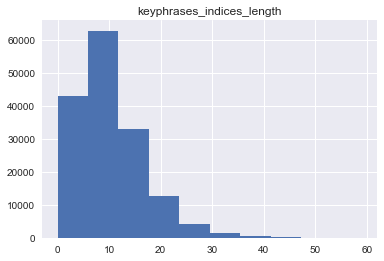

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline

cur_df.hist(column='keyphrases_indices_length')

In [ ]:
key_vector_index_list = [item for sublist in cur_df["keyVector"].values for item in sublist]
unique, counts = np.unique(key_vector_index_list, return_counts=True)
[(x, count) for count, x in sorted(zip(counts,keyphrases), key=lambda pair: pair[0], reverse=True)]

In [195]:
cur_df['UserIndex'] = cur_df[USER_ID].astype('category').cat.rename_categories(range(0, cur_df[USER_ID].nunique()))
cur_df['ItemIndex'] = cur_df[ITEM_ID].astype('category').cat.rename_categories(range(0, cur_df[ITEM_ID].nunique()))
cur_df['Binary'] = (cur_df[RATING] > 4)*1

df_user_name = cur_df[['UserIndex',USER_ID]]
df_item_name = cur_df[['ItemIndex',ITEM_ID]]

total_review = len(cur_df)

print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(cur_df['Binary'].tolist())))
print("Number of key Phrase: {0}".format(len(df_keyphrases)))
print("Number of reviews: {0}".format(total_review))

Number of User: 2343
Number of Item: 7456
Number of Positive Review: 36955
Number of key Phrase: 233
Number of reviews: 157038


In [196]:
print ('positive/all review ratio is around: ', round(36955/157038*100), "%")

positive/all review ratio is around:  24 %


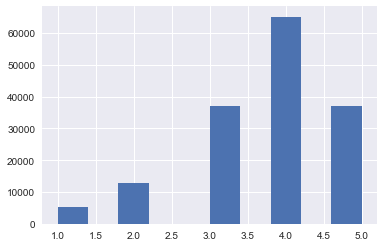

In [197]:
cur_df['rating'].hist()

# Save processed data

In [198]:
dataPath = '../../data/yelp/'

cur_df.to_csv(dataPath+'Data.csv')
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')

In [199]:
cur_df = pd.read_csv('../../data/yelp/Data.csv', index_col=0,  encoding='latin-1')

# Data Sparsity

In [201]:
len(cur_df)

157038

In [203]:
cur_df.loc[15][REVIEW_TEXT]

"This place is located inside Pacific Mall and I believe it's the first store in Toronto (I haven't encountered one like this yet). Apparently, it's very popular around the world, with locations all shown on their poster. As a promotion, they have buy 1 get 1, until the end of today! So today is a great idea to try it. I tried the Oreo milk tea because they ran out of their lemon mango slush. I thought it wasn't that great. The milk tea and the Oreo didn't go too well. I also tried the lemon black tea which was a lot better, maybe this is why their name is called happy lemon, as its their specialty. For the service, it was friendly but the wait took a long time! Because of their promotion, they told us to return in 30 minutes to get our drinks and it looks like their computers were down and it was cash only.Perhaps I will give this place another try, although for a large lemon tea, it was a bit pricey at $6.50."

In [171]:
cur_df[BINARY_RATING] = (cur_df[RATING] >= 4)*1

In [204]:
len(cur_df[cur_df[BINARY_RATING] == 1])

36955

In [205]:
cur_df['UserIndex'].nunique()

2343

In [206]:
cur_df['ItemIndex'].nunique()

7456

In [208]:
36955/(2343*7456)

0.0021154122681203624

In [209]:
print("Number of Positive Review: {0}".format(sum(cur_df[BINARY_RATING].tolist())))

Number of Positive Review: 36955


In [210]:
coverage_ratio = 1-len(cur_df[cur_df['keyphrases_indices_length'] == 0])/len(cur_df)
print('The current keyphrase set covers {}% reviews'.format(coverage_ratio * 100))
print(cur_df['keyphrases_indices_length'].mean())

The current keyphrase set covers 99.10594887861537% reviews
9.92481437613826


In [211]:
print('A review can have at most {} keyphrases in the current keyphrase set'.format(cur_df['keyphrases_indices_length'].max()))

A review can have at most 59 keyphrases in the current keyphrase set


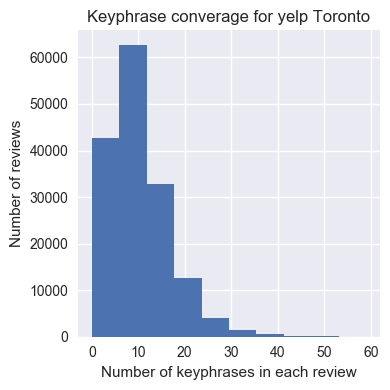

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1 = plt.figure(figsize=(4, 4), dpi=100)
ax1 = fig1.add_subplot(111)

cur_df.hist(column='keyphrases_indices_length', ax=ax1)

ax1.set_title("Keyphrase converage for yelp Toronto")
plt.xlabel('Number of keyphrases in each review')
plt.ylabel('Number of reviews')

# legend = plt.legend(loc='upper right', shadow=True,prop={'size':10})
plt.tight_layout()

In [216]:
plt.savefig('../figs/keyphrase converage for yelp Toronto')